In [1]:
import numpy as np
import xspec

xspec.AllData.clear()
xspec.AllModels.clear()

xspec.Xset.restore("model.xcm")

xspec.Fit.statMethod = "cstat"
xspec.Fit.bayes = "on"

xspec_observation = xspec.Spectrum("spectrum_opt.pha")
xspec_observation.background = None
low_energy, high_energy = 0.3, 12.
xspec_observation.ignore(f"0.0-{low_energy:.1f} {high_energy:.1f}-**")

xspec_model = xspec.AllModels(1)
xspec_model.show()

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
Parameter delta values for fits will now be 0.01 * parValue

 The default systematic error for models is set to 0

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.

Model TBabs<1>(compTT<2> + powerlaw<3>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp


In [2]:
from bsixsa.convenience import set_prior_and_build_transform

define_prior = [
    ("TBabs", "nH", 0.01, 0.2, "uniform"),       # 10^22    0.100000     +/-  0.0
    ("compTT", "T0", 0.05, 2.0, "uniform"),      #   keV      0.550000     +/-  0.0
    ("compTT", "kT", 2.1, 4.0, "uniform"),      #  keV      2.50000      +/-  0.0
    ("compTT", "taup", 0.5, 7, "uniform"),    #            2.50000      +/-  0.0
    ("compTT", "norm", 0.1, 10, "loguniform"),    #            1.00000      +/-  0.0
    ("powerlaw", "PhoIndex", 0.0, 5.0, "uniform"),  #          2.00000      +/-  0.0
    ("powerlaw", "norm", 0.01, 10, "loguniform")        #0.275000     +/-  0.0
]

transformations = set_prior_and_build_transform(xspec_model, define_prior)


Fit statistic  : C-Statistic                20680.85     using 2961 bins.
   (Includes a Bayesian contribution of -4.61)

Test statistic : Chi-Squared                13833.37     using 2961 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

  uniform prior for nH between 0.010000 and 0.200000 
  uniform prior for T0 between 0.050000 and 2.000000 
  uniform prior for kT between 2.100000 and 4.000000 
  uniform prior for taup between 0.500000 and 7.000000 
  jeffreys prior for norm between 1.000000e-01 and 1.000000e+01 
  uniform prior for PhoIndex between 0.000000 and 5.000000 
  jeffreys prior for norm between 1.000000e-02 and 1.000000e+01 
 Null hypothesis probability of 0.00e+00 with 2954 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                20679.65     using 2961 bins.
   (Includes a Bayesian contribution of -5.80)

Test statistic : Chi-Squared                13833.37  

In [3]:
from bsixsa import SIXSASolver

outputfiles_basename = "sixsa_result_mri_embedding/"

solver = SIXSASolver(
    transformations,
    outputfiles_basename=outputfiles_basename
)

In [13]:
from sbi.neural_nets.embedding_nets import (
    FCEmbedding
)

embedding = FCEmbedding(
    input_dim=len(xspec.AllData(1).values),
    output_dim=64,
    num_layers=4,
    num_hiddens=128,
)

In [ ]:
training_kwargs = dict(
    discard_prior_samples=False,
    force_first_round_loss=True,
    retrain_from_scratch=False,
)

posterior = solver.run(num_rounds=10, num_simulations=10_000, embedding=embedding, training_kwargs=training_kwargs)

Round 1 - Folding model:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 98 epochs.

Round 2 - Folding model:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 112 epochs.

Round 3 - Folding model:   0%|          | 0/10000 [00:00<?, ?it/s]

 Training neural network. Epochs trained: 72

In [6]:
chain = solver.chain_from_sample(solver.unit_cube_to_xspec(posterior.sample((10000,)).numpy().T), name="SIXSA MRI")

  0%|          | 0/100 [00:00<?, ?it/s]

The error "***XSPEC Error: Requested array does not exist for this plot." can be ignored.



***XSPEC Error: Requested array does not exist for this plot.


***Warning: Fit is not current.
***Warning: Fit is not current.


/Users/sdupourque/PycharmProjects/BXA/src/bsixsa/plotting_stuff.py:186: RuntimeWarning: divide by zero encountered in divide
  residuals = (total-y_observed)/(np.percentile(total, 84, axis=0) - np.percentile(total, 16, axis=0))
/Users/sdupourque/PycharmProjects/BXA/src/bsixsa/plotting_stuff.py:186: RuntimeWarning: invalid value encountered in divide
  residuals = (total-y_observed)/(np.percentile(total, 84, axis=0) - np.percentile(total, 16, axis=0))
/Users/sdupourque/miniforge3/envs/BXA/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


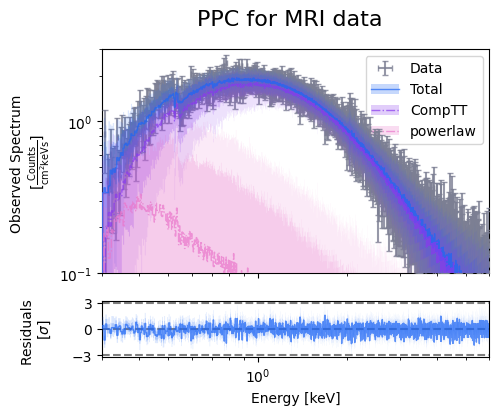

In [12]:
from bsixsa.plotting_stuff import plot_ppc
component_names = ["Total", "CompTT", "powerlaw"]

fig = plot_ppc(solver, component_names=component_names, x_lim=(0.3, 6.), y_lim=(1e-1, 3), figsize=(5,4))
fig.align_ylabels()
fig.suptitle("PPC for MRI data", fontsize=16);

/Users/sdupourque/miniforge3/envs/BXA/lib/python3.12/site-packages/chainconsumer/chain.py:301: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


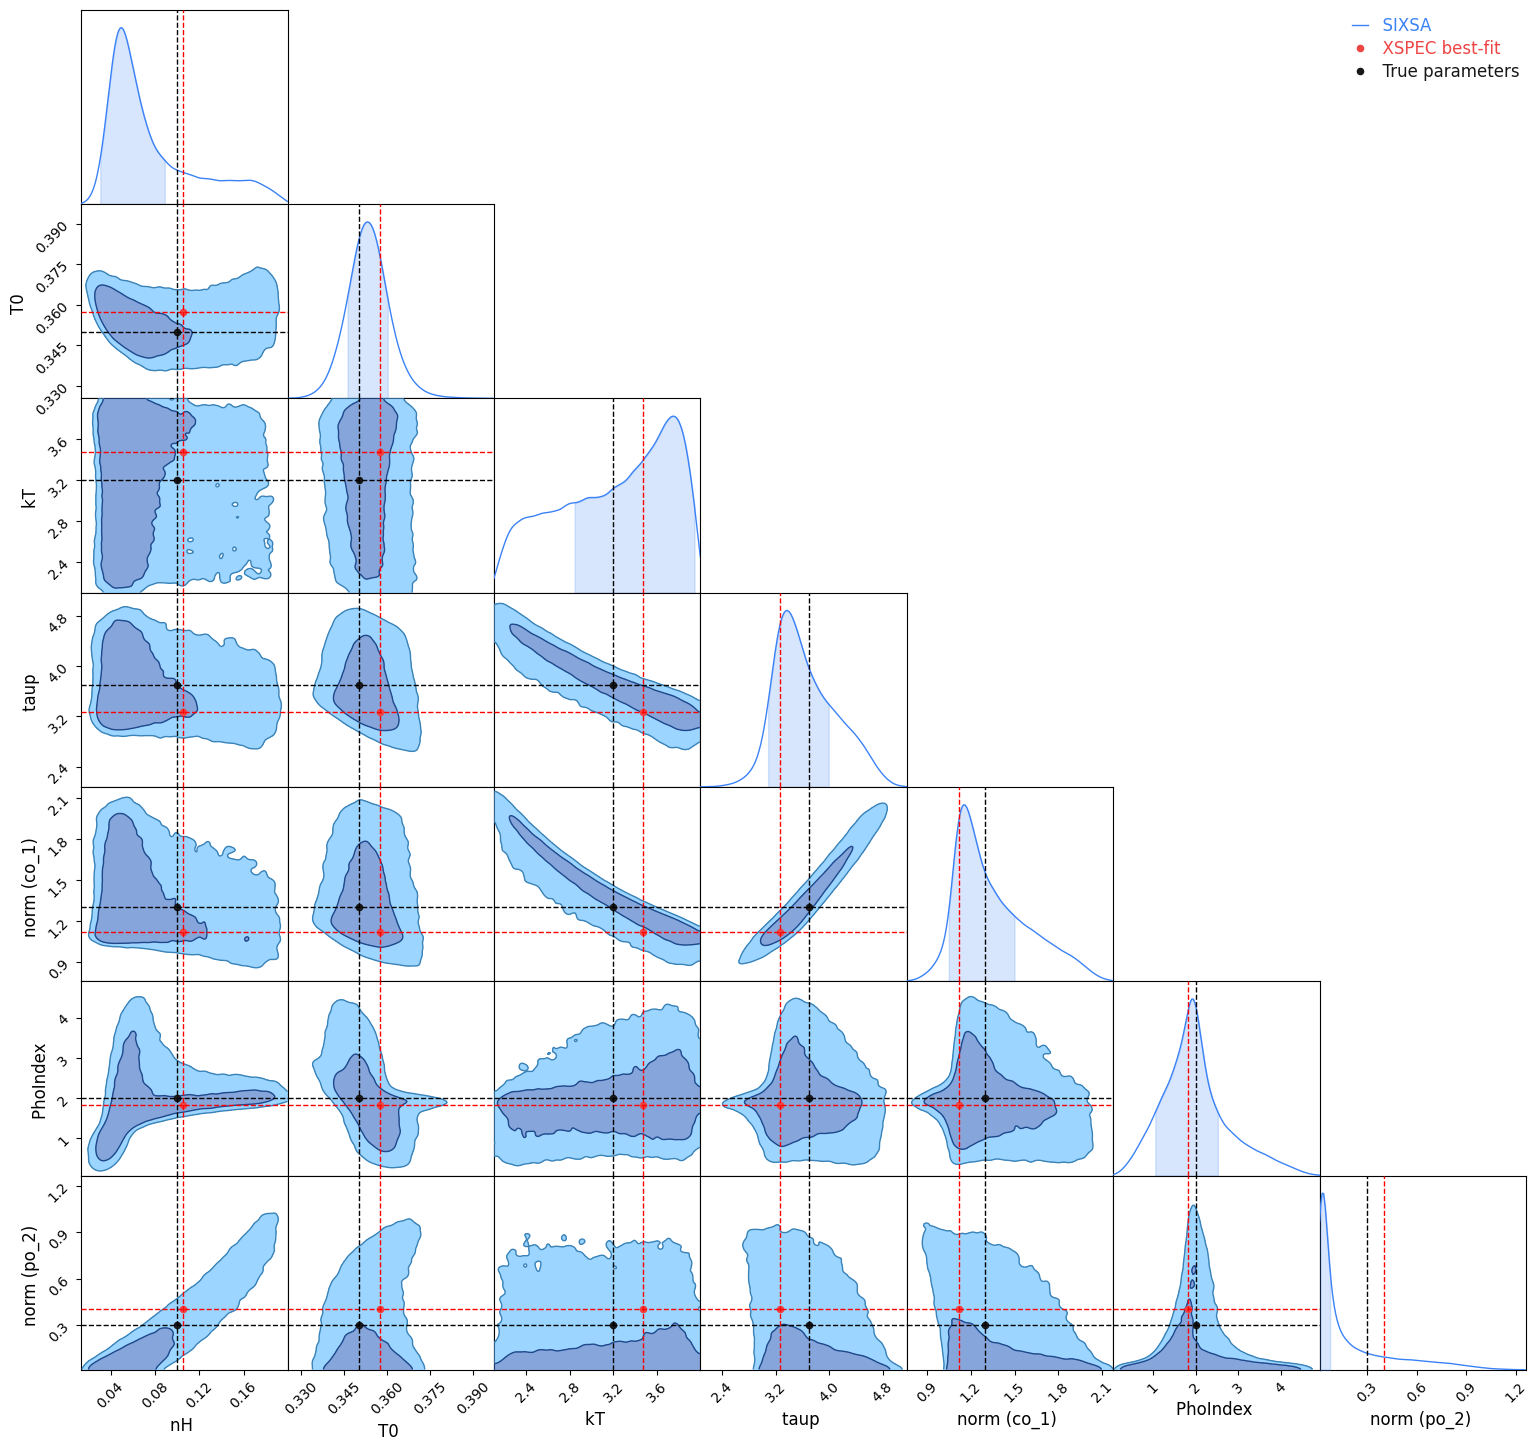

In [8]:
import pandas as pd
import numpy as np
from generate_ref_spectrum import truth
from chainconsumer import Chain, ChainConsumer, Truth

indexes = np.sort([t['index'] for t in solver.transformations])
parameter_names = np.asarray(solver.parameter_names_uniques)[indexes-1]

best_fit_parameters, covariance = solver.get_xspec_best_fit()

best_fit_parameters = best_fit_parameters[indexes-1]
xspec_cov = Chain.from_covariance(best_fit_parameters, covariance, columns=parameter_names, name="XSPEC with covariance")

samples = posterior.sample((100000,))
warped_samples = solver.unit_cube_to_xspec(samples.numpy().T)

dict_of_params = {}

for i in indexes:
    name = solver.parameter_names_uniques[i-1]
    dict_of_params[name] = np.asarray([warped_samples[j][i] for j in range(len(warped_samples))])

cc = ChainConsumer()
chain = Chain(samples=pd.DataFrame.from_dict(dict_of_params), name="SIXSA")

best_fit_loc = {name:np.ravel(best_fit_parameters)[i] for i, name in enumerate(parameter_names)}
truth = [truth[t["index"]] for t in solver.transformations]
truth_loc = {name:truth[i] for i, name in enumerate(parameter_names)}

cc.add_chain(chain)
#cc.add_chain(xspec_cov)
cc.add_truth(Truth(location=best_fit_loc, color="red"))
cc.add_truth(Truth(location=truth_loc, color="black"))
cc.add_marker(location=best_fit_loc, name="XSPEC best-fit", color="red", marker_style="o", marker_size=20)
cc.add_marker(location=truth_loc, name="True parameters", color="black", marker_style="o", marker_size=20)
cc.plotter.plot();

In [9]:
pd.DataFrame.from_dict(dict_of_params).to_csv("results_df/sixsa_mri_embedding.csv")